In [ ]:
from keras.layers.recurrent import 

In [84]:
import tensorflow as tf
from keras import backend as K
from keras import regularizers, constraints, initializers, activations
from keras.layers.recurrent import Recurrent, _time_distributed_dense
from keras.engine import InputSpec

tfPrint = lambda d, T: tf.Print(input_=T, data=[T, tf.shape(T)], message=d)

class AttentionDecoder(Recurrent):

    def __init__(self, units, output_dim,
                 activation='tanh',
                 return_probabilities=False,
                 name='AttentionDecoder',
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        """
        Implements an AttentionDecoder that takes in a sequence encoded by an
        encoder and outputs the decoded states 
        :param units: dimension of the hidden state and the attention matrices
        :param output_dim: the number of labels in the output space

        references:
            Bahdanau, Dzmitry, Kyunghyun Cho, and Yoshua Bengio. 
            "Neural machine translation by jointly learning to align and translate." 
            arXiv preprint arXiv:1409.0473 (2014).
        """
        self.units = units
        self.output_dim = output_dim
        self.return_probabilities = return_probabilities
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        super(AttentionDecoder, self).__init__(**kwargs)
        self.name = name
        self.return_sequences = True  # must return sequences

    def build(self, input_shape):
        """
          See Appendix 2 of Bahdanau 2014, arXiv:1409.0473
          for model details that correspond to the matrices here.
        """

        self.batch_size, self.timesteps, self.input_dim = input_shape

        if self.stateful:
            super(AttentionDecoder, self).reset_states()

        self.states = [None, None]  # y, s

        """
            Matrices for creating the context vector
        """

        self.V_a = self.add_weight(shape=(self.units,),
                                   name='V_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.W_a = self.add_weight(shape=(self.units, self.units),
                                   name='W_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.U_a = self.add_weight(shape=(self.input_dim, self.units),
                                   name='U_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.b_a = self.add_weight(shape=(self.units,),
                                   name='b_a',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for the r (reset) gate
        """
        self.C_r = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_r = self.add_weight(shape=(self.units, self.units),
                                   name='U_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_r = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_r = self.add_weight(shape=(self.units, ),
                                   name='b_r',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)

        """
            Matrices for the z (update) gate
        """
        self.C_z = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_z = self.add_weight(shape=(self.units, self.units),
                                   name='U_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_z = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_z = self.add_weight(shape=(self.units, ),
                                   name='b_z',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for the proposal
        """
        self.C_p = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_p = self.add_weight(shape=(self.units, self.units),
                                   name='U_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_p = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_p = self.add_weight(shape=(self.units, ),
                                   name='b_p',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for making the final prediction vector
        """
        self.C_o = self.add_weight(shape=(self.input_dim, self.output_dim),
                                   name='C_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_o = self.add_weight(shape=(self.units, self.output_dim),
                                   name='U_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_o = self.add_weight(shape=(self.output_dim, self.output_dim),
                                   name='W_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_o = self.add_weight(shape=(self.output_dim, ),
                                   name='b_o',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)

        # For creating the initial state:
        self.W_s = self.add_weight(shape=(self.input_dim, self.units),
                                   name='W_s',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)

        self.input_spec = [
            InputSpec(shape=(self.batch_size, self.timesteps, self.input_dim))]
        self.built = True

    def call(self, x):
        # store the whole sequence so we can "attend" to it at each timestep
        self.x_seq = x

        # apply the a dense layer over the time dimension of the sequence
        # do it here because it doesn't depend on any previous steps
        # thefore we can save computation time:
        self._uxpb = _time_distributed_dense(self.x_seq, self.U_a, b=self.b_a,
                                             input_dim=self.input_dim,
                                             timesteps=self.timesteps,
                                             output_dim=self.units)

        return super(AttentionDecoder, self).call(x)

    def get_initial_state(self, inputs):
        print('inputs shape:', inputs.get_shape())

        # apply the matrix on the first time step to get the initial s0.
        s0 = activations.tanh(K.dot(inputs[:, 0], self.W_s))

        # from keras.layers.recurrent to initialize a vector of (batchsize,
        # output_dim)
        y0 = K.zeros_like(inputs)  # (samples, timesteps, input_dims)
        y0 = K.sum(y0, axis=(1, 2))  # (samples, )
        y0 = K.expand_dims(y0)  # (samples, 1)
        y0 = K.tile(y0, [1, self.output_dim])

        return [y0, s0]

    def step(self, x, states):

        ytm, stm = states

        # repeat the hidden state to the length of the sequence
        _stm = K.repeat(stm, self.timesteps)

        # now multiplty the weight matrix with the repeated hidden state
        _Wxstm = K.dot(_stm, self.W_a)

        # calculate the attention probabilities
        # this relates how much other timesteps contributed to this one.
        et = K.dot(activations.tanh(_Wxstm + self._uxpb),
                   K.expand_dims(self.V_a))
        at = K.exp(et)
        at_sum = K.sum(at, axis=1)
        at_sum_repeated = K.repeat(at_sum, self.timesteps)
        at /= at_sum_repeated  # vector of size (batchsize, timesteps, 1)

        # calculate the context vector
        context = K.squeeze(K.batch_dot(at, self.x_seq, axes=1), axis=1)
        # ~~~> calculate new hidden state
        # first calculate the "r" gate:

        rt = activations.sigmoid(
            K.dot(ytm, self.W_r)
            + K.dot(stm, self.U_r)
            + K.dot(context, self.C_r)
            + self.b_r)

        # now calculate the "z" gate
        zt = activations.sigmoid(
            K.dot(ytm, self.W_z)
            + K.dot(stm, self.U_z)
            + K.dot(context, self.C_z)
            + self.b_z)

        # calculate the proposal hidden state:
        s_tp = activations.tanh(
            K.dot(ytm, self.W_p)
            + K.dot((rt * stm), self.U_p)
            + K.dot(context, self.C_p)
            + self.b_p)

        # new hidden state:
        st = (1-zt)*stm + zt * s_tp

        yt = activations.softmax(
            K.dot(ytm, self.W_o)
            + K.dot(stm, self.U_o)
            + K.dot(context, self.C_o)
            + self.b_o)

        if self.return_probabilities:
            return at, [yt, st]
        else:
            return yt, [yt, st]

    def compute_output_shape(self, input_shape):
        """
            For Keras internal compatability checking
        """
        if self.return_probabilities:
            return (None, self.timesteps, self.timesteps)
        else:
            return (None, self.timesteps, self.output_dim)

    def get_config(self):
        """
            For rebuilding models on load time.
        """
        config = {
            'output_dim': self.output_dim,
            'units': self.units,
            'return_probabilities': self.return_probabilities
        }
        base_config = super(AttentionDecoder, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



ImportError: cannot import name '_time_distributed_dense'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


In [2]:
num_points=1000
X = np.sin(np.linspace(0, 2*np.pi, num_points)).reshape((num_points, 1))
Y = np.cos(np.linspace(0, 2*np.pi, num_points))

In [3]:
X_o = X.reshape(1000, 1,1 )
Y_o = Y.reshape(1000, 1, )

In [4]:
train_X = X_o[:800]
test_X = X_o[800:]

train_Y = Y_o[:800]
test_Y = Y_o[800:]

In [5]:
time_steps = 5

In [6]:
q = pd.DataFrame(X)
q.shift(2).fillna(method='bfill').tail(10)



,0
990,-0.069129
991,-0.062853
992,-0.056575
993,-0.050295
994,-0.044012
995,-0.037728
996,-0.031442
997,-0.025155
998,-0.018867
999,-0.012579


In [7]:
pd.DataFrame(X).tail(10)

,0
990,-5.657505e-02
991,-5.029457e-02
992,-4.401210e-02
993,-3.772789e-02
994,-3.144219e-02
995,-2.515525e-02
996,-1.886730e-02
997,-1.257862e-02
998,-6.289433e-03
999,-2.449294e-16


In [10]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

Using TensorFlow backend.


In [11]:
# define the raw dataset
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# create mapping of characters to integers (0-25) and the reverse
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

In [12]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 3
dataX = []
dataY = []
for i in range(0, len(alphabet) - seq_length, 1):
    seq_in = alphabet[i:i + seq_length]
    seq_out = alphabet[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
    print(seq_in, '->', seq_out)

ABC -> D
BCD -> E
CDE -> F
DEF -> G
EFG -> H
FGH -> I
GHI -> J
HIJ -> K
IJK -> L
JKL -> M
KLM -> N
LMN -> O
MNO -> P
NOP -> Q
OPQ -> R
PQR -> S
QRS -> T
RST -> U
STU -> V
TUV -> W
UVW -> X
VWX -> Y
WXY -> Z


In [13]:
X = numpy.reshape(dataX, (len(dataX), seq_length, 1))

In [14]:
X.shape

(23, 3, 1)

In [15]:
X = X / float(len(alphabet))

In [16]:
X

array([[[ 0.        ],
        [ 0.03846154],
        [ 0.07692308]],

       [[ 0.03846154],
        [ 0.07692308],
        [ 0.11538462]],

       [[ 0.07692308],
        [ 0.11538462],
        [ 0.15384615]],

       [[ 0.11538462],
        [ 0.15384615],
        [ 0.19230769]],

       [[ 0.15384615],
        [ 0.19230769],
        [ 0.23076923]],

       [[ 0.19230769],
        [ 0.23076923],
        [ 0.26923077]],

       [[ 0.23076923],
        [ 0.26923077],
        [ 0.30769231]],

       [[ 0.26923077],
        [ 0.30769231],
        [ 0.34615385]],

       [[ 0.30769231],
        [ 0.34615385],
        [ 0.38461538]],

       [[ 0.34615385],
        [ 0.38461538],
        [ 0.42307692]],

       [[ 0.38461538],
        [ 0.42307692],
        [ 0.46153846]],

       [[ 0.42307692],
        [ 0.46153846],
        [ 0.5       ]],

       [[ 0.46153846],
        [ 0.5       ],
        [ 0.53846154]],

       [[ 0.5       ],
        [ 0.53846154],
        [ 0.57692308]],

      

In [17]:
y = np_utils.to_categorical(dataY)

In [18]:
y.shape

(23, 26)

In [19]:
# create and fit the model
model = Sequential()
model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=500, batch_size=1, verbose=2)

Epoch 1/500
 - 1s - loss: 3.2654 - acc: 0.0435
Epoch 2/500
 - 0s - loss: 3.2516 - acc: 0.0435
Epoch 3/500
 - 0s - loss: 3.2421 - acc: 0.0435
Epoch 4/500
 - 0s - loss: 3.2344 - acc: 0.0435
Epoch 5/500
 - 0s - loss: 3.2261 - acc: 0.0435
Epoch 6/500
 - 0s - loss: 3.2173 - acc: 0.0435
Epoch 7/500
 - 0s - loss: 3.2079 - acc: 0.0435
Epoch 8/500
 - 0s - loss: 3.1975 - acc: 0.0435
Epoch 9/500
 - 0s - loss: 3.1853 - acc: 0.0435
Epoch 10/500
 - 0s - loss: 3.1724 - acc: 0.0435
Epoch 11/500
 - 0s - loss: 3.1575 - acc: 0.0435
Epoch 12/500
 - 0s - loss: 3.1430 - acc: 0.0435
Epoch 13/500
 - 0s - loss: 3.1278 - acc: 0.0435
Epoch 14/500
 - 0s - loss: 3.1088 - acc: 0.0435
Epoch 15/500
 - 0s - loss: 3.0936 - acc: 0.0435
Epoch 16/500
 - 0s - loss: 3.0738 - acc: 0.0435
Epoch 17/500
 - 0s - loss: 3.0562 - acc: 0.0435
Epoch 18/500
 - 0s - loss: 3.0398 - acc: 0.0435
Epoch 19/500
 - 0s - loss: 3.0201 - acc: 0.0435
Epoch 20/500
 - 0s - loss: 3.0058 - acc: 0.0435
Epoch 21/500
 - 0s - loss: 2.9811 - acc: 0.0870
E

Epoch 171/500
 - 0s - loss: 1.0536 - acc: 0.9130
Epoch 172/500
 - 0s - loss: 1.0447 - acc: 0.8696
Epoch 173/500
 - 0s - loss: 1.0419 - acc: 0.8696
Epoch 174/500
 - 0s - loss: 1.0303 - acc: 0.9130
Epoch 175/500
 - 0s - loss: 1.0289 - acc: 0.9130
Epoch 176/500
 - 0s - loss: 1.0208 - acc: 0.9130
Epoch 177/500
 - 0s - loss: 1.0165 - acc: 0.9130
Epoch 178/500
 - 0s - loss: 1.0148 - acc: 0.9565
Epoch 179/500
 - 0s - loss: 1.0096 - acc: 0.8696
Epoch 180/500
 - 0s - loss: 0.9985 - acc: 0.9565
Epoch 181/500
 - 0s - loss: 0.9985 - acc: 0.9130
Epoch 182/500
 - 0s - loss: 0.9867 - acc: 0.9130
Epoch 183/500
 - 0s - loss: 0.9933 - acc: 0.9130
Epoch 184/500
 - 0s - loss: 0.9826 - acc: 0.8696
Epoch 185/500
 - 0s - loss: 0.9799 - acc: 0.8696
Epoch 186/500
 - 0s - loss: 0.9702 - acc: 0.9130
Epoch 187/500
 - 0s - loss: 0.9671 - acc: 0.9130
Epoch 188/500
 - 0s - loss: 0.9601 - acc: 0.9130
Epoch 189/500
 - 0s - loss: 0.9519 - acc: 0.9565
Epoch 190/500
 - 0s - loss: 0.9506 - acc: 0.9565
Epoch 191/500
 - 0s 

KeyboardInterrupt: 

In [20]:
# demonstrate some model predictions
for pattern in dataX:
    x = numpy.reshape(pattern, (1, len(pattern), 1))
    x = x / float(len(alphabet))
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    print(seq_in, "->", result)

['A', 'B', 'C'] -> D
['B', 'C', 'D'] -> E
['C', 'D', 'E'] -> F
['D', 'E', 'F'] -> G
['E', 'F', 'G'] -> H
['F', 'G', 'H'] -> I
['G', 'H', 'I'] -> J
['H', 'I', 'J'] -> K
['I', 'J', 'K'] -> L
['J', 'K', 'L'] -> M
['K', 'L', 'M'] -> N
['L', 'M', 'N'] -> O
['M', 'N', 'O'] -> P
['N', 'O', 'P'] -> Q
['O', 'P', 'Q'] -> R
['P', 'Q', 'R'] -> S
['Q', 'R', 'S'] -> T
['R', 'S', 'T'] -> U
['S', 'T', 'U'] -> U
['T', 'U', 'V'] -> W
['U', 'V', 'W'] -> X
['V', 'W', 'X'] -> Y
['W', 'X', 'Y'] -> Z


In [77]:
time_points = np.linspace(0, 8*np.pi, 8000)

seq_length = 100
dataX = []
dataY = []
for i in range(0, len(time_points) - seq_length, 1):
    seq_in = np.sin(time_points)[i:i + seq_length]
    seq_out = 2*np.sin(time_points)[i] + 5*np.cos(time_points[i]) + 3*np.cos(time_points[i]/4) + 2*np.cos(time_points[i]/2)
    dataX.append([seq_in])
    dataY.append(seq_out)
    #print(seq_in, '->', seq_out)

In [78]:
X = numpy.reshape(dataX, (len(dataX), seq_length, 1))
y = np.reshape(dataY, (len(dataY), 1))

In [79]:
X.shape

(7900, 100, 1)

In [80]:
# create and fit the model
model = Sequential()
model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2]), activation='linear', recurrent_dropout=0.2, return_sequences=False))
#model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2])))

#model.add(LSTM(8, input_shape=(X.shape[1], X.shape[2]), activation='linear', recurrent_dropout=0.2, return_sequences=False))




model.add(Dense(y.shape[1], activation='linear'))




model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X[:6000], y[:6000], epochs=200, batch_size=200, verbose=2, validation_split=0.3)

Train on 4200 samples, validate on 1800 samples
Epoch 1/200
 - 4s - loss: 19.7875 - val_loss: 17.5747
Epoch 2/200
 - 2s - loss: 41600132109.6835 - val_loss: 17.1974
Epoch 3/200
 - 2s - loss: 17.8105 - val_loss: 17.2247
Epoch 4/200
 - 2s - loss: 17.9100 - val_loss: 17.2290
Epoch 5/200
 - 2s - loss: 17.9229 - val_loss: 17.2296
Epoch 6/200
 - 2s - loss: 17.9244 - val_loss: 17.2296
Epoch 7/200
 - 2s - loss: 17.9245 - val_loss: 17.2296
Epoch 8/200
 - 2s - loss: 17.9245 - val_loss: 17.2296
Epoch 9/200
 - 2s - loss: 17.9245 - val_loss: 17.2296
Epoch 10/200
 - 2s - loss: 17.9245 - val_loss: 17.2296
Epoch 11/200
 - 2s - loss: 17.9245 - val_loss: 17.2296
Epoch 12/200
 - 2s - loss: 17.9245 - val_loss: 17.2296
Epoch 13/200
 - 2s - loss: 17.9245 - val_loss: 17.2295
Epoch 14/200
 - 2s - loss: 17.9245 - val_loss: 17.2295
Epoch 15/200
 - 2s - loss: 17.9244 - val_loss: 17.2295
Epoch 16/200
 - 2s - loss: 17.9244 - val_loss: 17.2295
Epoch 17/200
 - 2s - loss: 17.9244 - val_loss: 17.2295
Epoch 18/200
 - 2

 - 2s - loss: 17.9165 - val_loss: 17.2215
Epoch 149/200
 - 2s - loss: 17.9164 - val_loss: 17.2213
Epoch 150/200
 - 2s - loss: 17.9162 - val_loss: 17.2212
Epoch 151/200
 - 2s - loss: 17.9161 - val_loss: 17.2211
Epoch 152/200
 - 2s - loss: 17.9160 - val_loss: 17.2210
Epoch 153/200
 - 2s - loss: 17.9159 - val_loss: 17.2208
Epoch 154/200
 - 2s - loss: 17.9157 - val_loss: 17.2207
Epoch 155/200
 - 2s - loss: 17.9156 - val_loss: 17.2206
Epoch 156/200
 - 2s - loss: 17.9155 - val_loss: 17.2204
Epoch 157/200
 - 2s - loss: 17.9153 - val_loss: 17.2203
Epoch 158/200
 - 2s - loss: 17.9152 - val_loss: 17.2202
Epoch 159/200
 - 2s - loss: 17.9151 - val_loss: 17.2200
Epoch 160/200
 - 2s - loss: 17.9149 - val_loss: 17.2199
Epoch 161/200
 - 2s - loss: 17.9148 - val_loss: 17.2198
Epoch 162/200
 - 2s - loss: 17.9147 - val_loss: 17.2196
Epoch 163/200
 - 2s - loss: 17.9145 - val_loss: 17.2195
Epoch 164/200
 - 2s - loss: 17.9144 - val_loss: 17.2193
Epoch 165/200
 - 2s - loss: 17.9142 - val_loss: 17.2192
Epoch 

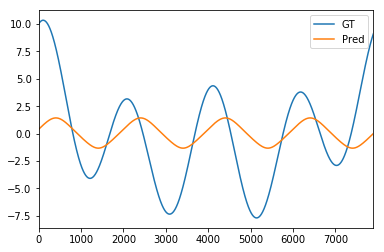

In [82]:
pd.DataFrame(y)[:][0].plot(label='GT')
pd.DataFrame(model.predict(X))[:][0].plot(label='Pred')
plt.legend()

In [26]:
import seq2seq
from seq2seq.models import SimpleSeq2Seq

model = SimpleSeq2Seq(input_dim=1, hidden_dim=10, output_length=8, output_dim=1)
model.compile(loss='mse', optimizer='rmsprop')

In [28]:
model.fit(np.sin(np.linspace(0, 1, 100)), np.cos(np.linspace(0, 1, 100)), epochs=30, batch_size=200, verbose=2, validation_split=0.3)

ValueError: Error when checking input: expected input_4 to have 3 dimensions, but got array with shape (100, 1)